## Import Packages

In [42]:
#import packages
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import requests
import configparser
import pickle
import string
import nltk
from copy import deepcopy

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer

#modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve


import time
import collections
from PIL import Image
import sys

## Get Data

In [2]:
#import key for tmdb API
config = configparser.ConfigParser()
config.read('API_KEYS.ini')
config.sections()

API_KEY = config['tmdb.com']['API_KEY']

tmdb.API_KEY = API_KEY

In [3]:
#import data
genome_tags_ids = pd.read_csv('data/genome-tags.csv')
movies = pd.read_csv('data/movies.csv')
genome_tags = pd.read_csv('data/genome-scores.csv')
user_tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

In [4]:
#create movie lookup table
movies = movies.merge(links, left_on = 'movieId', right_on = 'movieId', how = 'left')
movies.dropna(subset=['tmdbId'], inplace=True)
movies['tmdbId'] = movies['tmdbId'].astype(int)
movies.loc[movies['movieId'] == 4207, 'tmdbId'] = 427910
movies.loc[movies['movieId'] == 4568, 'tmdbId'] = 207340
movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357
4,5,Father of the Bride Part II (1995),Comedy,113041,11862


In [5]:
#create genome tag data; 1 record per movie per tag 
genome_tags = genome_tags.merge(genome_tags_ids, left_on = 'tagId', right_on = 'tagId', how = 'left')
genome_tags = genome_tags.merge(movies[['title', 'movieId', 'tmdbId']], left_on = 'movieId', right_on = 'movieId', how = 'left')
genome_tags = genome_tags[genome_tags['tmdbId'].notnull()]
genome_tags['tmdbId'] = genome_tags['tmdbId'].astype(int)
genome_tags.head()

,movieId,tagId,relevance,tag,title,tmdbId
0,1,1,0.02475,007,Toy Story (1995),862
1,1,2,0.02475,007 (series),Toy Story (1995),862
2,1,3,0.04900,18th century,Toy Story (1995),862
3,1,4,0.07750,1920s,Toy Story (1995),862
4,1,5,0.12450,1930s,Toy Story (1995),862


In [6]:
genome_tags['tag'].nunique()

1128

## Clean Movie Tags

Each movie is given a score for each of 1100 tags.  That is too many tags to predict given a dataset of 10000 movies.  Let's concentrate on those tags that are highest scoring.  If we take the top 5 tags for any given movie, that may allow us to narrow our tags set. We can also eliminate tags that are not content related (ie: based on a book, Oscar winner, etc)

Text(0.5,1,'Movies with tag in top 5 list')

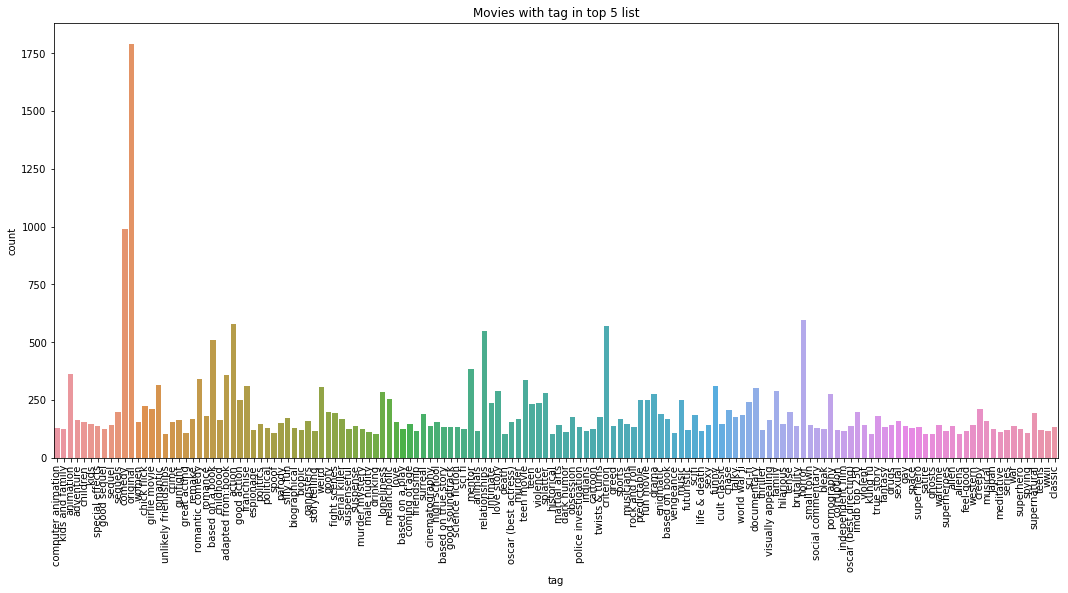

In [7]:
#get top 5 tags per movie
top5 = genome_tags.sort_values(by=['movieId', 'relevance', 'tagId'], ascending = [True, False, True]).groupby('movieId').head(5)
top5.head()

#Get list of top 5 tags
tagslist = top5.tag.value_counts()
tagslist = tagslist[tagslist > 100]
tagslist = list(tagslist.index.values)  

top5 = top5.loc[top5['tag'].isin(tagslist)]

fig, ax = plt.subplots(figsize=(18,8))
ax = sns.countplot(x = "tag", data = top5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Movies with tag in top 5 list")

In [8]:
#keep tags that are in top5 for any movie
genome_tags = genome_tags.loc[genome_tags['tag'].isin(tagslist)]
genome_tags = genome_tags.pivot(index='movieId', columns='tag', values='relevance')
genome_tags.columns = map(str.lower, genome_tags.columns)
genome_tags.columns = genome_tags.columns.str.replace(' ', '_')

#drop tags that should not be predicted based on picture
genome_tags.columns.values

drop_cols = ['adapted_from:book',
             'based_on_a_book', 
             'based_on_a_play',
             'based_on_book', 
             'based_on_true_story', 
             'cinematography', 
             'classic',
             'computer_animation',
             'criterion', 
             'cult_classic',
             'franchise', 
             'good_sequel', 
             'good_soundtrack',
             'great_acting',
             'imdb_top_250', 
             'male_nudity', 
             'original',
             'oscar_(best_actress)', 
             'oscar_(best_directing)', 
             'parody',
             'predictable', 
             'remake',
             'sequel', 
             'sequels',
             'series',
             'special_effects',
             'storytelling']
genome_tags.drop(columns = drop_cols, inplace = True)

In [9]:
#examine genome tag data
genome_tags.head()

,action,adventure,alien,aliens,animals,animation,biographical,biopic,bleak,brutality,...,violence,violent,visually_appealing,war,wartime,weird,western,women,world_war_ii,wwii
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.65025,0.89800,0.13850,0.25350,0.69200,0.98650,0.11625,0.09975,0.11750,0.24150,...,0.28350,0.19600,0.40675,0.06375,0.09200,0.32300,0.02275,0.10850,0.04300,0.03600
2,0.62825,0.97975,0.03725,0.05575,0.91150,0.13725,0.08475,0.05375,0.04975,0.23100,...,0.17100,0.13450,0.18850,0.04175,0.04625,0.30275,0.01275,0.12750,0.01650,0.01325
3,0.15575,0.42900,0.03100,0.04250,0.09125,0.02650,0.04350,0.03450,0.06850,0.29825,...,0.11575,0.10175,0.21950,0.03675,0.06600,0.17125,0.03500,0.37375,0.02650,0.01725
4,0.13825,0.12975,0.02375,0.02975,0.13075,0.04450,0.03150,0.03175,0.05075,0.31475,...,0.17225,0.09125,0.18425,0.03250,0.05425,0.16725,0.03000,0.97575,0.02150,0.01325
5,0.15475,0.15250,0.03225,0.03500,0.12850,0.02675,0.05625,0.03800,0.06125,0.26600,...,0.10500,0.08375,0.19375,0.03400,0.05700,0.25750,0.02400,0.46200,0.01875,0.01325


In [10]:
genome_tags.shape[1]

121

## Tag Clustering

121 Tags are still too many, so let's cluster similar tags together.  Use correlation matrix to cluster similar tags together.  Identify and name clusters to result in 45 tags. Use the max value of tags to get score per tag cluster and turn tag scores into a binary yes/no variable based on arbitrary cut-off (0.75) 

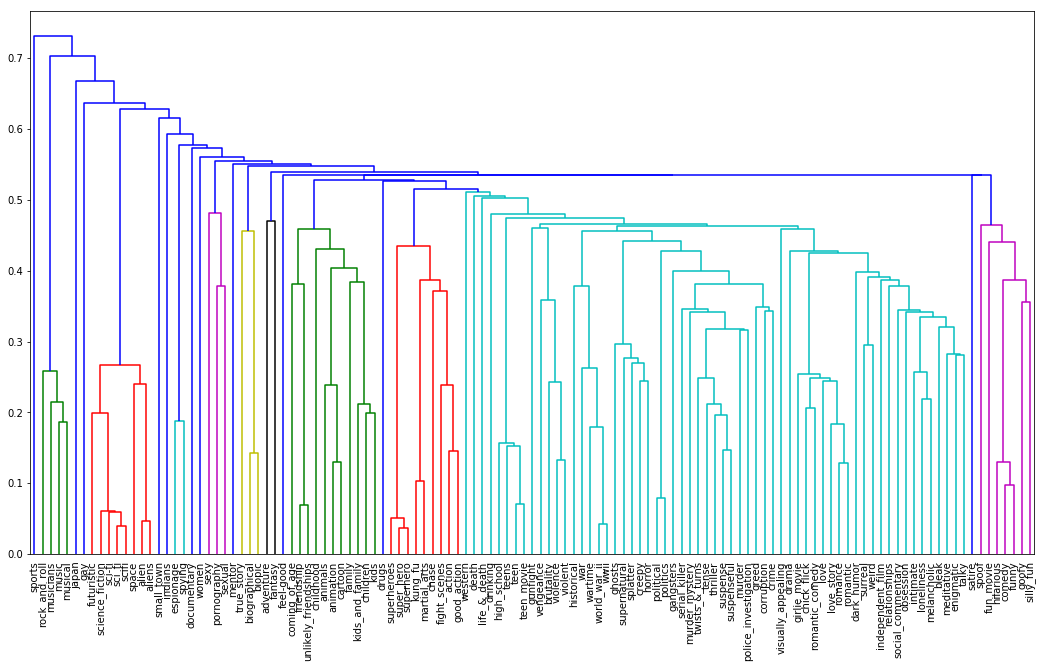

In [11]:
#get correlation matrix for each tag
corr = genome_tags.corr()

#change to distance matrix using 
corr = 1- corr
corr.head()

cond_dist = squareform(corr)

Z = linkage(cond_dist)
fig, ax = plt.subplots(figsize=(18, 10))
g = dendrogram(Z, ax = ax, labels=corr.index)
ax.tick_params(axis = 'x', which = 'major', labelsize = 10)
plt.show()

In [12]:
#set cut point at 0.4
cutree = cut_tree(Z, height = 0.40)
cutree = np.reshape(cutree, -1)

#name tag clusters
var_clusters = pd.DataFrame({'tag' : corr.index,
                            'cluster': cutree})
var_clusters.sort_values(by = 'cluster')
cluster_tags = {
    0: 'action',
    1: 'adventure',
    2: 'scifi',
    3: 'animation',
    4: 'biopic',
    5: 'melancholic_wierd',
    6: 'violent',
    7: 'romance',
    8: 'childhood', 
    9: 'family',
    10: 'comedy', 
    11: 'friendships', 
    12: 'crime',
    13: 'horror', 
    14: 'death', 
    15: 'documentary', 
    16: 'drama', 
    17: 'drugs', 
    18: 'drinking',
    19: 'spy',
    20: 'fantasy', 
    21: 'feel_good',
    22: 'fun', 
    23: 'gangsters', 
    24: 'gay',
    25: 'gunfight',
    26: 'teen', 
    27: 'war',
    28: 'indians', 
    29: 'japan', 
    30: 'life_death',
    31: 'mentor', 
    32: 'music', 
    33: 'political', 
    34: 'sexual', 
    35: 'satire', 
    36: 'sexy', 
    37: 'smalltown', 
    38: 'spoof', 
    39: 'sports', 
    40: 'superhero', 
    41: 'true story', 
    42: 'visual',
    43: 'western',
    44: 'women'
}

topics = list(cluster_tags.values())

In [13]:
#reduce tags to max value per cluster
genome_tags = pd.melt(genome_tags.reset_index(), id_vars = 'movieId', var_name='tag', value_name='relevance')
genome_tags = genome_tags.merge(var_clusters, left_on = 'tag', right_on = 'tag', how = "left")
genome_tags = pd.DataFrame(genome_tags.groupby(['movieId', 'cluster'])['relevance'].max()).reset_index()
genome_tags['cluster_label'] = genome_tags.cluster.map(cluster_tags)
genome_tags = genome_tags.pivot(index='movieId', columns='cluster_label', values='relevance')

In [14]:
#create master tags dataset with title and linking IDs
genome_tags = genome_tags.merge(movies[['title', 'tmdbId', 'movieId']] , left_index = True, right_on = 'movieId', how = 'left')

In [15]:
#make genome tags binary; anything with score > 0.75 is true
genome_tags_binary = genome_tags.drop(['title', 'tmdbId', 'movieId'], axis = 1) > 0.75
genome_tags_binary = (genome_tags_binary*1).apply(pd.to_numeric)
genome_tags_binary[['movieId', 'title', 'tmdbId']] = genome_tags[['movieId','title', 'tmdbId']]
genome_tags_binary.head()

,action,adventure,animation,biopic,childhood,comedy,crime,death,documentary,drama,...,teen,true story,violent,visual,war,western,women,movieId,title,tmdbId
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Toy Story (1995),862
1,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,Jumanji (1995),8844
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,Grumpier Old Men (1995),15602
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,Waiting to Exhale (1995),31357
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,Father of the Bride Part II (1995),11862


In [16]:
#review movies per tag
genome_tags_binary[topics].sum(axis = 0).sort_values(ascending = False)

melancholic_wierd    3641
crime                2260
comedy               1605
action               1535
violent              1265
romance              1235
mentor               1228
drama                1072
horror               1037
visual                843
family                822
scifi                 706
war                   643
sexual                638
fun                   627
friendships           624
teen                  617
animation             578
childhood             548
music                 494
adventure             425
documentary           383
true story            360
feel_good             357
political             355
gunfight              344
life_death            319
biopic                312
gangsters             297
sexy                  293
fantasy               290
drugs                 275
death                 260
women                 255
spy                   246
smalltown             233
drinking              230
satire                219
superhero   

## Get Movie Overviews

Use tmdb API to get movie overviews for each tagged movie. This can take some time so save result to use for later.

In [17]:
'''
overviews = collections.defaultdict(dict)

movie_list = genome_tags[['movieId', 'title', 'tmdbId']]

for i in movie_list['tmdbId']:
    try:
        #api call to get movie poster path
        movie = tmdb.Movies(i)
        movie.info()
    
    except requests.exceptions.HTTPError:
        print("tmbdId %s doesn't exist" %i)
        overviews[i]['tmdbId_exist'] = 0
        continue
    
    else:
        overviews[i]['tmdbId_exist'] = 1
        overviews[i]['overview'] = movie.info()['overview']
        overviews[i]['title'] = movie.info()['title']
        time.sleep(.5)

overviews_df = pd.DataFrame.from_dict(overviews, orient = 'index')


#pickle movie overviews
with open('overviews_df.pickle', 'wb') as handle:
    pickle.dump(overviews_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''

'\noverviews = collections.defaultdict(dict)\n\nmovie_list = genome_tags[[\'movieId\', \'title\', \'tmdbId\']]\n\nfor i in movie_list[\'tmdbId\']:\n    try:\n        #api call to get movie poster path\n        movie = tmdb.Movies(i)\n        movie.info()\n    \n    except requests.exceptions.HTTPError:\n        print("tmbdId %s doesn\'t exist" %i)\n        overviews[i][\'tmdbId_exist\'] = 0\n        continue\n    \n    else:\n        overviews[i][\'tmdbId_exist\'] = 1\n        overviews[i][\'overview\'] = movie.info()[\'overview\']\n        overviews[i][\'title\'] = movie.info()[\'title\']\n        time.sleep(.5)\n\noverviews_df = pd.DataFrame.from_dict(overviews, orient = \'index\')\n\n\n#pickle movie overviews\nwith open(\'overviews_df.pickle\', \'wb\') as handle:\n    pickle.dump(overviews_df, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n'

## Create final dataset

Final dataset should be a list of 10000 movies, 49 binary flags for each of the tag clusters, and the text overview

In [18]:
#Merge number of competitors to listings data
with open('overviews_df.pickle', 'rb') as handle:
    overviews_df = pickle.load(handle)

In [19]:
overviews_df.head()

,tmdbId_exist,overview,title
2,1,Taisto Kasurinen is a Finnish coal miner whose...,Ariel
5,1,It's Ted the Bellhop's first night on the job....,Four Rooms
6,1,"While racing to a boxing match, Frank, Mike, J...",Judgment Night
11,1,Princess Leia is captured and held hostage by ...,Star Wars
12,1,"Nemo, an adventurous young clownfish, is unexp...",Finding Nemo


In [20]:
print('Overview for Toy Story')
overviews_df['overview'][862]

Overview for Toy Story


"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [21]:
overviews_df = overviews_df.reset_index().rename(columns={'index':'tmdbId'})
overviews_df.overview=overviews_df.overview.astype(str)
final= pd.merge(overviews_df, genome_tags_binary, left_on = 'tmdbId', right_on = 'tmdbId')

In [22]:
#remove those with null overviews
final = final[final['overview'] != 'nan']

In [23]:
len(final)

10907

In [24]:
final.head()

,tmdbId,tmdbId_exist,overview,title_x,action,adventure,animation,biopic,childhood,comedy,...,superhero,teen,true story,violent,visual,war,western,women,movieId,title_y
0,2,1,Taisto Kasurinen is a Finnish coal miner whose...,Ariel,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4470,Ariel (1988)
1,5,1,It's Ted the Bellhop's first night on the job....,Four Rooms,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18,Four Rooms (1995)
2,6,1,"While racing to a boxing match, Frank, Mike, J...",Judgment Night,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,479,Judgment Night (1993)
3,11,1,Princess Leia is captured and held hostage by ...,Star Wars,1,1,0,0,1,0,...,0,0,0,0,1,1,0,0,260,Star Wars: Episode IV - A New Hope (1977)
4,12,1,"Nemo, an adventurous young clownfish, is unexp...",Finding Nemo,0,1,1,0,1,1,...,0,0,0,0,1,0,0,0,6377,Finding Nemo (2003)


## Modeling

Split dataset into training and test sets.  Use one tag as outcome for now.  

Feature set should be Tf-IDF matrix of overview text with stop words removed and lemmitization applied.  Try with vocabulary of 800 terms (~10% of training instances)

In [25]:
X_train, X_test, y_train, y_test, title_train, title_test = train_test_split(final['overview'], final['action'], final['title_x'], test_size = 0.33, random_state = 412)

In [26]:
#Create a list of classifiers to test

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemming(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    stems = [stem for stem in stems if len(stem) >= 3]
    return stems


pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.4, min_df= 0.01)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])


In [27]:
pipeline_2 = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.5, min_df= 0.01)),])

In [28]:
output = pipeline_2.fit(X_train)

In [29]:
len(list(pipeline_2.named_steps['vect'].vocabulary_.keys()))

478

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params, pipeline):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.pipeline = pipeline

    def fit(self, X, y, cv=5, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            pipeline.set_params(clf = model)
            paramgrid = self.params[key]
            gs = GridSearchCV(pipeline, param_grid = paramgrid, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values(by = [sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [40]:
# Compute ROC curve and ROC area
def roc_stats(X_test, y_test, model):
    
    #generate data
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    y_predict = model.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    #print stats
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict))
    print('Accuracy: %.3f%%' % (accuracy*100))
    print('Recall: %.3f%%' % (recall*100))
    print('Precision: %.3f%%' % (precision*100))

In [82]:
def viz_pos_terms(X_train, y_train, cvec, model):
    term_freq_df = pd.DataFrame(cvec.transform(X_train).toarray())
    term_freq_df['target'] = y_train.reset_index(drop = True)

    
    neg_tf = term_freq_df[term_freq_df['target'] == 0].drop(['target'], axis=1).sum()
    pos_tf = term_freq_df[term_freq_df['target'] == 1].drop(['target'], axis=1).sum()
    
    term_freq_df2 = pd.DataFrame([neg_tf,pos_tf])
    term_freq_df2.columns = cvec.get_feature_names()
    term_freq_df2 = term_freq_df2.transpose()
    term_freq_df2.columns = ['negative', 'positive']
    term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
    term_freq_df2['positive_rate'] = term_freq_df2['positive']/term_freq_df2['total'] 
    term_freq_df2['negative_rate'] = term_freq_df2['negative']/term_freq_df2['total'] 
    term_freq_df2.sort_values(by='positive_rate', ascending=False).iloc[:10]
    
    #make plot
    y_pos = np.arange(50)
    plt.figure(figsize=(12,10))
    plt.bar(y_pos, term_freq_df2.sort_values(by='positive_rate', ascending=False)['positive_rate'][:50], align='center', alpha=0.5)
    plt.xticks(y_pos, term_freq_df2.sort_values(by='positive_rate', ascending=False)['positive_rate'][:50].index,rotation='vertical')
    plt.ylabel('Frequency')
    plt.xlabel('Top 50 positive tokens')
    plt.title('Top 50 tokens in positive overviews')

## Action

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

models1 = {
#    'RandomForestClassifier': RandomForestClassifier(),
#    'AdaBoostClassifier': AdaBoostClassifier(),
#    'GradientBoostingClassifier': GradientBoostingClassifier(),
#    'SVC': SVC(),
    'SGDClassifier': SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight = 'balanced', max_iter = 120)
}

params1 = {
    'RandomForestClassifier': { 'clf__n_estimators': [16, 32] },
#    'AdaBoostClassifier':  { 'clf__n_estimators': [16, 32] },
#    'GradientBoostingClassifier': { 'clf__n_estimators': [16, 32], 'clf__learning_rate': [0.8, 1.0] },
#    'SVC': [
#        {'clf__kernel': ['linear'], 'clf__C': [1, 10]},
#        {'clf__kernel': ['rbf'], 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]},
#    ],
    'SGDClassifier': {'vect__max_df' : [0.4, 0.5, 0.7],
                      'vect__min_df' : [0.01, 0.075, 0.005],
                      'clf__l1_ratio' :  np.linspace(0,1,8)
                     }
}


helper1 = EstimatorSelectionHelper(models1, params1, pipeline)
model = helper1.fit(X_train, y_train, scoring='recall', n_jobs=2)
helper1.score_summary()

Running GridSearchCV for SGDClassifier.
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 28.6min


SGDClassifier


[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed: 52.5min finished


,estimator,min_score,mean_score,max_score,std_score,clf__l1_ratio,vect__max_df,vect__min_df
0,SGDClassifier,0.653465,0.681095,0.724138,0.0280477,0,0.4,0.01
3,SGDClassifier,0.653465,0.681095,0.724138,0.0280477,0,0.5,0.01
6,SGDClassifier,0.653465,0.680105,0.724138,0.0289051,0,0.7,0.01
9,SGDClassifier,0.643564,0.67715,0.714286,0.027321,0.142857,0.4,0.01
12,SGDClassifier,0.648515,0.67616,0.714286,0.0275326,0.142857,0.5,0.01
24,SGDClassifier,0.643564,0.67616,0.70936,0.0277118,0.285714,0.7,0.01
21,SGDClassifier,0.643564,0.67616,0.70936,0.0277118,0.285714,0.5,0.01
15,SGDClassifier,0.643564,0.67616,0.714286,0.0278864,0.142857,0.7,0.01
7,SGDClassifier,0.594059,0.67613,0.73399,0.0461212,0,0.7,0.075
18,SGDClassifier,0.643564,0.675174,0.70936,0.0265784,0.285714,0.4,0.01


Classifiers perform similarly so try hyperparameter tuning with Logistic Regression

In [84]:
pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.5, min_df= 0.01)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, l1_ratio = 0, class_weight = 'balanced')),
])

model = pipeline.fit(X_train, y_train)

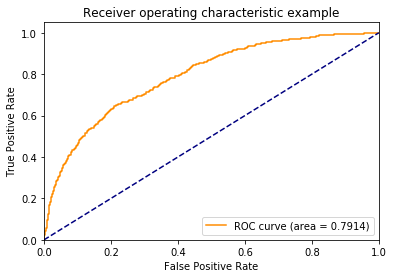

Confusion Matrix: 
 [[2314  773]
 [ 169  344]]
Accuracy: 73.833%
Recall: 67.057%
Precision: 30.797%


In [85]:
roc_stats(X_test, y_test, model=model)

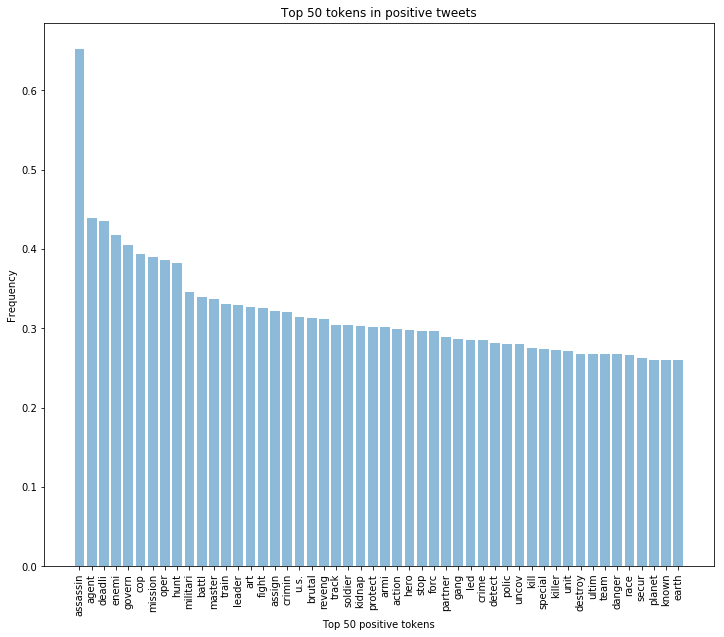

In [86]:
cvec = deepcopy(pipeline.named_steps['vect'])
viz_pos_terms(X_train, y_train, cvec=cvec)

## Melanchlolic Wierd

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test, title_train, title_test = train_test_split(final['overview'], final['melancholic_wierd'], final['title_x'], test_size = 0.33, random_state = 412)

models1 = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'SGDClassifier': SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight = 'balanced', max_iter = 120)
}

params1 = {
    'RandomForestClassifier': { 'clf__n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'clf__n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'clf__n_estimators': [16, 32], 'clf__learning_rate': [0.8, 1.0] },#
    'SVC': [
        {'clf__kernel': ['linear'], 'clf__C': [1, 10]},
        {'clf__kernel': ['rbf'], 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]},
    ],
    'SGDClassifier': {
                      'clf__l1_ratio' :  np.linspace(0,1,8)
                     }
}


helper1 = EstimatorSelectionHelper(models1, params1, pipeline)
model = helper1.fit(X_train, y_train, scoring='recall', n_jobs=2)
helper1.score_summary()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.7min finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.5min finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  3.1min finished


Running GridSearchCV for SGDClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  5.6min finished


RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC
SGDClassifier


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  5.9min finished
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__gamma,clf__kernel,clf__l1_ratio,clf__learning_rate,clf__n_estimators
21,SGDClassifier,0.569647,0.588861,0.624481,0.0201923,NaN,NaN,NaN,1,NaN,NaN
20,SGDClassifier,0.56639,0.580973,0.612033,0.0165298,NaN,NaN,NaN,0.857143,NaN,NaN
19,SGDClassifier,0.565489,0.580137,0.616183,0.0191242,NaN,NaN,NaN,0.714286,NaN,NaN
17,SGDClassifier,0.561331,0.579305,0.607884,0.0170897,NaN,NaN,NaN,0.428571,NaN,NaN
14,SGDClassifier,0.553015,0.576395,0.60166,0.0181609,NaN,NaN,NaN,0,NaN,NaN
18,SGDClassifier,0.559252,0.575984,0.609959,0.0186,NaN,NaN,NaN,0.571429,NaN,NaN
16,SGDClassifier,0.555094,0.575982,0.603734,0.0173512,NaN,NaN,NaN,0.285714,NaN,NaN
15,SGDClassifier,0.553015,0.57598,0.603734,0.0187313,NaN,NaN,NaN,0.142857,NaN,NaN
9,SVC,0.278008,0.294856,0.324324,0.0186199,10,NaN,linear,NaN,NaN,NaN
7,GradientBoostingClassifier,0.268191,0.289862,0.307054,0.0133248,NaN,NaN,NaN,NaN,1,32


In [88]:
pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.5, min_df= 0.01)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, l1_ratio = 1, class_weight = 'balanced')),
])

model = pipeline.fit(X_train, y_train)

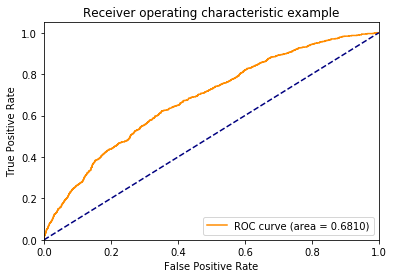

Confusion Matrix: 
 [[1573  826]
 [ 471  730]]
Accuracy: 63.972%
Recall: 60.783%
Precision: 46.915%


In [89]:
roc_stats(X_test, y_test, model=model)

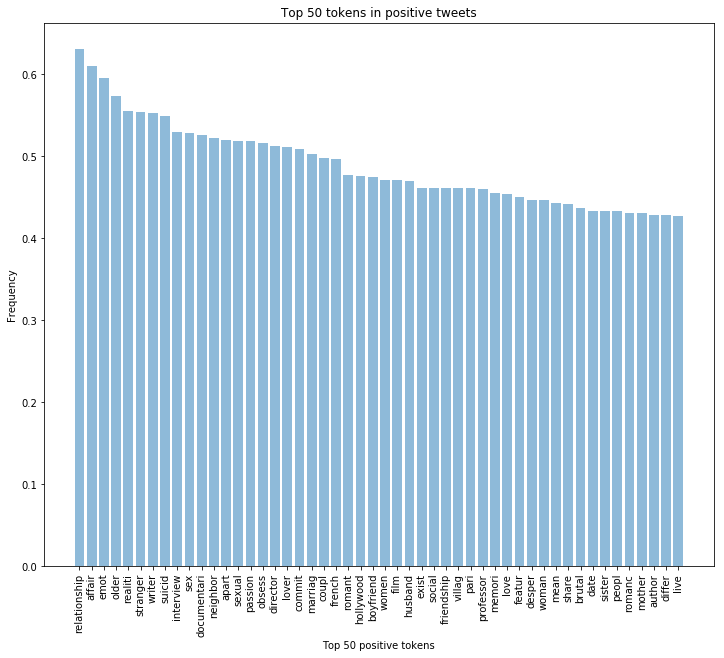

In [90]:
cvec = deepcopy(pipeline.named_steps['vect'])
viz_pos_terms(X_train, y_train, cvec=cvec)

# Comedy

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test, title_train, title_test = train_test_split(final['overview'], final['comedy'], final['title_x'], test_size = 0.33, random_state = 412)

models1 = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'SGDClassifier': SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight = 'balanced', max_iter = 120)
}

params1 = {
    'RandomForestClassifier': { 'clf__n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'clf__n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'clf__n_estimators': [16, 32], 'clf__learning_rate': [0.8, 1.0] },#
    'SVC': [
        {'clf__kernel': ['linear'], 'clf__C': [1, 10]},
        {'clf__kernel': ['rbf'], 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]},
    ],
    'SGDClassifier': {
                      'clf__l1_ratio' :  np.linspace(0,1,8)
                     }
}


helper1 = EstimatorSelectionHelper(models1, params1, pipeline)
model = helper1.fit(X_train, y_train, scoring='recall', n_jobs=2)
helper1.score_summary()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.6min finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.5min finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  3.1min finished


Running GridSearchCV for SGDClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  4.8min finished


RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC
SGDClassifier


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  5.6min finished
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__gamma,clf__kernel,clf__l1_ratio,clf__learning_rate,clf__n_estimators
18,SGDClassifier,0.570776,0.596737,0.671233,0.037685,NaN,NaN,NaN,0.571429,NaN,NaN
17,SGDClassifier,0.56621,0.59582,0.666667,0.0360484,NaN,NaN,NaN,0.428571,NaN,NaN
15,SGDClassifier,0.56621,0.594902,0.671233,0.0387598,NaN,NaN,NaN,0.142857,NaN,NaN
14,SGDClassifier,0.561644,0.594894,0.657534,0.0330508,NaN,NaN,NaN,0,NaN,NaN
19,SGDClassifier,0.568182,0.594002,0.666667,0.037038,NaN,NaN,NaN,0.714286,NaN,NaN
16,SGDClassifier,0.570776,0.593989,0.666667,0.0366226,NaN,NaN,NaN,0.285714,NaN,NaN
20,SGDClassifier,0.563636,0.591266,0.671233,0.0404189,NaN,NaN,NaN,0.857143,NaN,NaN
21,SGDClassifier,0.557078,0.590353,0.675799,0.043489,NaN,NaN,NaN,1,NaN,NaN
7,GradientBoostingClassifier,0.109589,0.120444,0.146119,0.0137788,NaN,NaN,NaN,NaN,1,32
5,GradientBoostingClassifier,0.0913242,0.103109,0.114155,0.00854571,NaN,NaN,NaN,NaN,0.8,32


In [92]:
pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.5, min_df= 0.01)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, l1_ratio = 0.428571, class_weight = 'balanced')),
])

model = pipeline.fit(X_train, y_train)

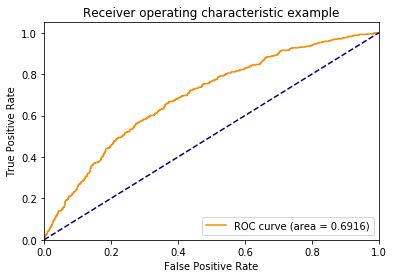

Confusion Matrix: 
 [[2129  963]
 [ 207  301]]
Accuracy: 67.500%
Recall: 59.252%
Precision: 23.813%


In [93]:
roc_stats(X_test, y_test, model=model)

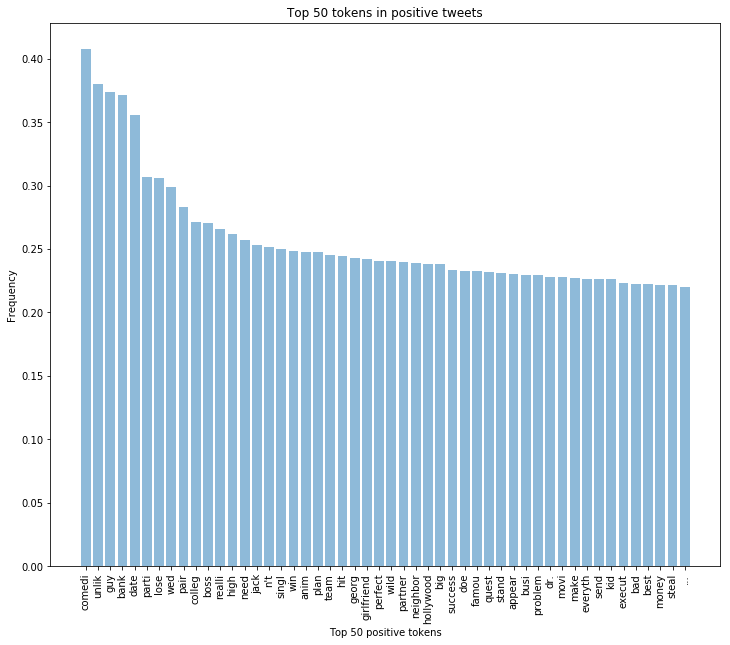

In [94]:
cvec = deepcopy(pipeline.named_steps['vect'])
viz_pos_terms(X_train, y_train, cvec=cvec)

# Romance

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test, title_train, title_test = train_test_split(final['overview'], final['romance'], final['title_x'], test_size = 0.33, random_state = 412)

models1 = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'SGDClassifier': SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight = 'balanced', max_iter = 120)
}

params1 = {
    'RandomForestClassifier': { 'clf__n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'clf__n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'clf__n_estimators': [16, 32], 'clf__learning_rate': [0.8, 1.0] },#
    'SVC': [
        {'clf__kernel': ['linear'], 'clf__C': [1, 10]},
        {'clf__kernel': ['rbf'], 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]},
    ],
    'SGDClassifier': {
                      'clf__l1_ratio' :  np.linspace(0,1,8)
                     }
}


helper1 = EstimatorSelectionHelper(models1, params1, pipeline)
model = helper1.fit(X_train, y_train, scoring='recall', n_jobs=2)
helper1.score_summary()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.4min finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.4min finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.8min finished


Running GridSearchCV for SGDClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  4.7min finished


RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC
SGDClassifier


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  5.6min finished
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__gamma,clf__kernel,clf__l1_ratio,clf__learning_rate,clf__n_estimators
14,SGDClassifier,0.575758,0.606061,0.636364,0.0223504,NaN,NaN,NaN,0,NaN,NaN
15,SGDClassifier,0.575758,0.603636,0.624242,0.0208541,NaN,NaN,NaN,0.142857,NaN,NaN
17,SGDClassifier,0.581818,0.602424,0.630303,0.0193939,NaN,NaN,NaN,0.428571,NaN,NaN
16,SGDClassifier,0.581818,0.602424,0.630303,0.0193939,NaN,NaN,NaN,0.285714,NaN,NaN
18,SGDClassifier,0.575758,0.6,0.624242,0.0206417,NaN,NaN,NaN,0.571429,NaN,NaN
19,SGDClassifier,0.569697,0.597576,0.624242,0.0231892,NaN,NaN,NaN,0.714286,NaN,NaN
20,SGDClassifier,0.563636,0.592727,0.618182,0.0231258,NaN,NaN,NaN,0.857143,NaN,NaN
21,SGDClassifier,0.563636,0.585455,0.612121,0.0197691,NaN,NaN,NaN,1,NaN,NaN
7,GradientBoostingClassifier,0.139394,0.175758,0.2,0.0202827,NaN,NaN,NaN,NaN,1,32
5,GradientBoostingClassifier,0.157576,0.175758,0.187879,0.0101413,NaN,NaN,NaN,NaN,0.8,32


In [96]:
pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.5, min_df= 0.01)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, l1_ratio = 0.142857, class_weight = 'balanced')),
])

model = pipeline.fit(X_train, y_train)

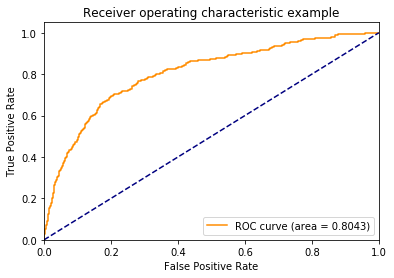

Confusion Matrix: 
 [[2483  713]
 [ 118  286]]
Accuracy: 76.917%
Recall: 70.792%
Precision: 28.629%


In [97]:
roc_stats(X_test, y_test, model=model)

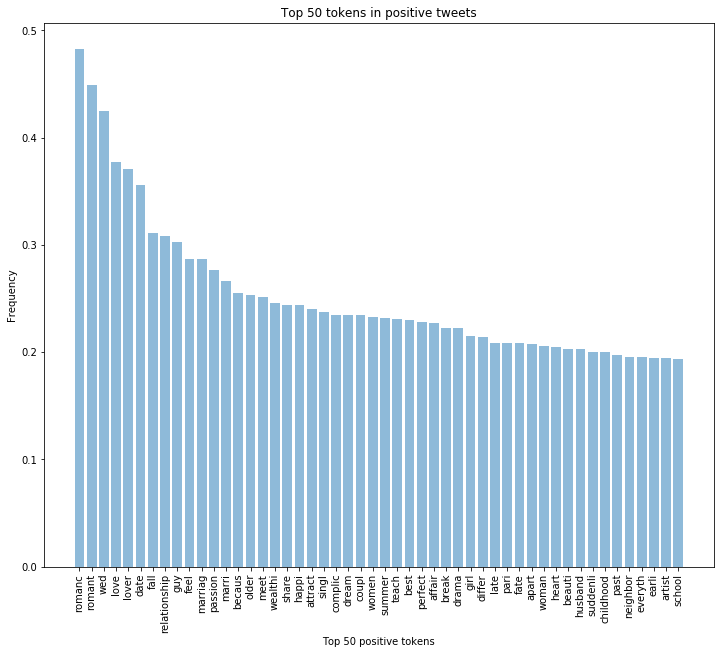

In [98]:
cvec = deepcopy(pipeline.named_steps['vect'])
viz_pos_terms(X_train, y_train, cvec=cvec)

# Horror

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test, title_train, title_test = train_test_split(final['overview'], final['horror'], final['title_x'], test_size = 0.33, random_state = 412)

models1 = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'SGDClassifier': SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight = 'balanced', max_iter = 120)
}

params1 = {
    'RandomForestClassifier': { 'clf__n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'clf__n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'clf__n_estimators': [16, 32], 'clf__learning_rate': [0.8, 1.0] },#
    'SVC': [
        {'clf__kernel': ['linear'], 'clf__C': [1, 10]},
        {'clf__kernel': ['rbf'], 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]},
    ],
    'SGDClassifier': {
                      'clf__l1_ratio' :  np.linspace(0,1,8)
                     }
}


helper1 = EstimatorSelectionHelper(models1, params1, pipeline)
model = helper1.fit(X_train, y_train, scoring='recall', n_jobs=2)
helper1.score_summary()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.4min finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.4min finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.8min finished


Running GridSearchCV for SGDClassifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  4.6min finished


RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC
SGDClassifier


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  5.6min finished
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__gamma,clf__kernel,clf__l1_ratio,clf__learning_rate,clf__n_estimators
19,SGDClassifier,0.57554,0.645021,0.697842,0.0400166,NaN,NaN,NaN,0.714286,NaN,NaN
14,SGDClassifier,0.597122,0.642144,0.669065,0.0278187,NaN,NaN,NaN,0,NaN,NaN
18,SGDClassifier,0.57554,0.640705,0.690647,0.037222,NaN,NaN,NaN,0.571429,NaN,NaN
17,SGDClassifier,0.57554,0.639276,0.669065,0.0328182,NaN,NaN,NaN,0.428571,NaN,NaN
15,SGDClassifier,0.589928,0.639256,0.669065,0.0290667,NaN,NaN,NaN,0.142857,NaN,NaN
16,SGDClassifier,0.582734,0.634929,0.661871,0.0292416,NaN,NaN,NaN,0.285714,NaN,NaN
20,SGDClassifier,0.57554,0.63202,0.669065,0.0332683,NaN,NaN,NaN,0.857143,NaN,NaN
21,SGDClassifier,0.57554,0.629121,0.669065,0.0357156,NaN,NaN,NaN,1,NaN,NaN
9,SVC,0.130435,0.165864,0.223022,0.032787,10,NaN,linear,NaN,NaN,NaN
7,GradientBoostingClassifier,0.115942,0.151434,0.18705,0.0253491,NaN,NaN,NaN,NaN,1,32


In [100]:
pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700, max_df =  0.5, min_df= 0.01)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120, l1_ratio = 0, class_weight = 'balanced')),
])

model = pipeline.fit(X_train, y_train)

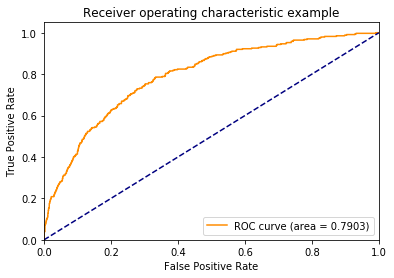

Confusion Matrix: 
 [[2588  676]
 [ 124  212]]
Accuracy: 77.778%
Recall: 63.095%
Precision: 23.874%


In [101]:
roc_stats(X_test, y_test, model=model)

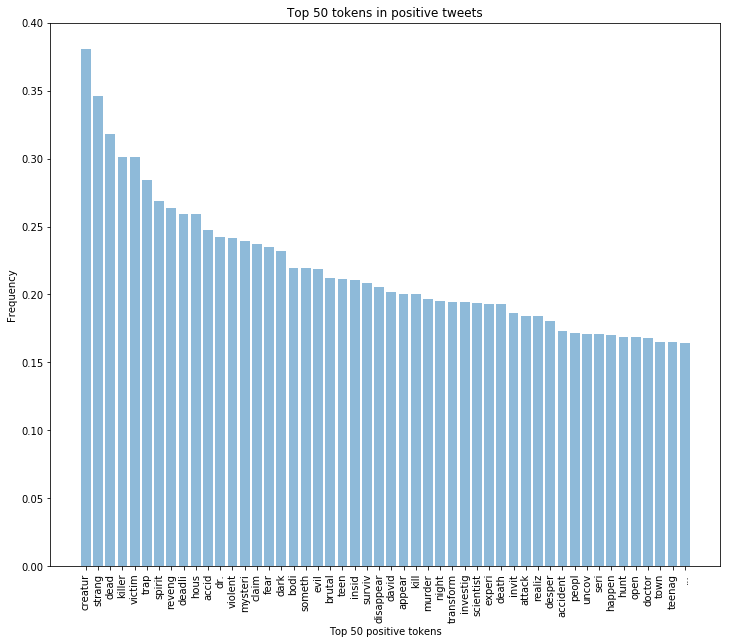

In [102]:
cvec = deepcopy(pipeline.named_steps['vect'])
viz_pos_terms(X_train, y_train, cvec=cvec)

## Doc2Vec

In [103]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [104]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [105]:
tagged_data

[TaggedDocument(words=['a', 'movie', 'that', 'starts', 'out', 'with', 'the', '``', 'man', 'in', 'the', 'mirror', "''", 'music', 'video', ',', 'it', 'then', 'changes', 'to', 'a', 'montage', 'of', 'video', 'clips', 'of', 'michael', "'s", 'career', '.', 'next', 'comes', 'a', 'parody', 'of', 'his', 'bad', 'video', 'by', 'children', ',', 'and', 'then', 'michael', 'is', 'chased', 'by', 'fans', 'in', 'a', 'fantasy', 'sequence', '.', '2', 'more', 'videos', 'are', 'shown', ',', 'and', 'then', 'a', 'movie', 'in', 'which', 'michael', 'plays', 'a', 'hero', 'with', 'magical', 'powers', '.', 'in', 'it', 'he', 'is', 'chased', 'by', 'drug', 'dealer', 'mr.', 'big', 'and', 'saves', 'three', 'children', '.', 'videos', 'included', 'in', 'the', 'movie', 'are', '``', 'smooth', 'criminal', "''", 'and', '``', 'come', 'together', "''", '.'], tags=['0']),
 TaggedDocument(words=['ash', 'ketchum', 'must', 'put', 'his', 'skill', 'to', 'the', 'test', 'when', 'he', 'attempts', 'to', 'save', 'the', 'world', 'from', '

In [107]:
model = Doc2Vec(vector_size=20, min_count=2, epochs=40)

In [148]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=3,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_movie.model")
print("Model Saved")

iteration 0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [149]:
model= Doc2Vec.load("d2v_movie.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("Hero finds villian".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

V1_infer [ 0.05124967 -0.02099926  0.07695504 -0.03505215  0.00177161  0.03154699
 -0.03536056  0.06329263  0.05765406 -0.04175119  0.00326821  0.08941355
 -0.02753117  0.01836449  0.02267539  0.03081121 -0.05519548 -0.00986067
 -0.01007915 -0.01793772]
[('2063', 0.7894545793533325), ('3885', 0.759668231010437), ('6426', 0.7568264603614807), ('1842', 0.7393337488174438), ('5374', 0.7356501817703247), ('4629', 0.7114452123641968), ('6620', 0.7098832130432129), ('1621', 0.7091977000236511), ('7265', 0.7027304768562317), ('3474', 0.7017586827278137)]
[-1.7838162  0.5505231  4.8086433  0.3596511 -3.5919106  8.400086
  3.1141417 10.300332   3.42913   -7.7146344  1.0675443  8.747963
 -5.548848   4.1523457 -5.7463126 -0.593978  -7.4564576 -2.8122258
  6.6765637  0.2996625]


/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [132]:
model.docvecs['1']

array([ 5.453438  ,  4.6410737 ,  3.4363055 ,  1.8558794 ,  0.05871608,
       -0.10559651, -0.87677854,  7.85961   , -2.211983  , -2.2613528 ,
       -2.2177875 ,  3.1709461 , -2.29288   , -1.9065224 ,  0.42572755,
       -1.3295819 , -3.047149  , -4.231495  ,  0.8852671 , -1.4365487 ,
        0.72642475, -4.7803    , -0.248364  , -2.1745093 ,  3.0065362 ,
        2.3274338 , -0.15477571,  0.09483647, -8.036373  ,  1.7828168 ,
        2.4435275 ,  5.344232  ,  2.5348914 ,  3.5667324 ,  2.8584206 ,
       -0.44667453, -3.2768288 , -1.5308992 ,  6.201628  , -2.1299915 ,
        2.8739936 , -5.401486  ,  0.9567715 ,  1.6289065 ,  0.7467901 ,
       -6.9307866 , -4.4613686 , -6.028727  ,  3.6472538 , -1.0140294 ],
      dtype=float32)

In [150]:
model.docvecs['2063']

array([-4.729262 , -3.7174015,  8.972684 , -0.7736916, -2.9448614,
        3.1735232,  6.000452 ,  9.330614 , -2.0519915, -4.5334406,
        2.2050066,  6.696753 , -4.8945346,  1.1477336, -4.5065455,
        3.7259872, -4.739782 ,  2.576508 ,  2.036649 ,  1.0570744],
      dtype=float32)

In [153]:
X_train.iloc[1]

'Ash Ketchum must put his skill to the test when he attempts to save the world from destruction. The Greedy Pokemon collector Lawrence III throws the universe into chaos after disrupting the balance of nature by capturing one of the Pokemon birds that rule the elements of fire, lightning and ice. Will Ash have what it takes to save the world?'

In [154]:
X_train.iloc[2063]

"The adventure explodes into action with the debut of Mewtwo, a bio-engineered Pokemon created from the DNA of Mew, the rarest of all Pokemon. Determined to prove its superiority, Mewtwo lures Ash, Pikachu and others into a Pokemon match like none before. Mewtwo vs. Mew. Super-clones vs. Pokemon. It's the ultimate showdown ... with the very future of the world at stake!"

In [155]:
X_train.iloc[3885]

"The world's most shagadelic spy continues his fight against Dr. Evil. This time, the diabolical doctor and his clone, Mini-Me, team up with a new foe -- '70s kingpin Goldmember. While pursuing the team of villains to stop them from world domination, Austin gets help from his dad and an old girlfriend."

In [156]:
X_train.iloc[6426]

'As humanity picks up the pieces, following the conclusion of "Transformers: Dark of the Moon," Autobots and Decepticons have all but vanished from the face of the planet. However, a group of powerful, ingenious businessman and scientists attempt to learn from past Transformer incursions and push the boundaries of technology beyond what they can control - all while an ancient, powerful Transformer menace sets Earth in his cross-hairs.'

In [140]:
inferred_vector = model.infer_vector(tagged_data[1].words)

In [141]:
model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('5976', 0.6878674626350403),
 ('3893', 0.6824896335601807),
 ('4353', 0.6802457571029663),
 ('1457', 0.678872287273407),
 ('3467', 0.6784921884536743),
 ('5482', 0.674129068851471),
 ('7083', 0.6723968386650085),
 ('1179', 0.6638568043708801),
 ('4460', 0.6633425951004028),
 ('1259', 0.661284327507019),
 ('4932', 0.6606590151786804),
 ('734', 0.6567493677139282),
 ('3831', 0.6513277888298035),
 ('33', 0.6503757834434509),
 ('5292', 0.650318443775177),
 ('3116', 0.6500539183616638),
 ('1520', 0.6480534076690674),
 ('473', 0.6478185653686523),
 ('575', 0.6455327868461609),
 ('3854', 0.639115035533905),
 ('6244', 0.6381747126579285),
 ('6703', 0.6377968788146973),
 ('3439', 0.6377931833267212),
 ('1974', 0.6336174011230469),
 ('3990', 0.6323911547660828),
 ('6267', 0.6300411820411682),
 ('150', 0.6298848986625671),
 ('4586', 0.6281760334968567),
 ('6573', 0.6268630027770996),
 ('4674', 0.6258928179740906),
 ('2368', 0.6247273087501526),
 ('142', 0.6243048310279846),
 ('911', 0.624206840

In [160]:
model.docvecs[0]

array([-1.1421406 ,  2.3328586 ,  7.123885  , -1.3174212 ,  1.2847414 ,
        6.2807837 ,  1.6044841 , -2.3338606 , -0.36768463, -0.70026827,
        1.6896651 ,  3.8712742 , -2.13924   ,  0.32764488, -5.682214  ,
        1.5148857 , -7.1916413 ,  6.6480374 , -1.0208929 ,  3.3616352 ],
      dtype=float32)

In [183]:
inferred_vector = model.infer_vector(tagged_data[].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
#rank = [docid for docid, sim in sims].index(str(doc_id))

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [186]:
second_ranks

[('2243', 0.64815354347229),
 ('1', 0.6144481301307678),
 ('5025', 0.6185070872306824),
 ('3116', 0.648666262626648),
 ('4', 0.6224873661994934),
 ('3427', 0.6597685813903809),
 ('575', 0.6325411200523376),
 ('4296', 0.6262302398681641),
 ('4532', 0.6366049647331238),
 ('4532', 0.6623695492744446),
 ('3854', 0.6329745054244995),
 ('6020', 0.6344209909439087),
 ('5689', 0.6435345411300659),
 ('3854', 0.6434792280197144),
 ('4532', 0.6470493674278259),
 ('5689', 0.6405668258666992),
 ('5025', 0.6444027423858643),
 ('3896', 0.6428147554397583),
 ('4532', 0.6745301485061646),
 ('19', 0.7094555497169495),
 ('61', 0.70383220911026),
 ('522', 0.6498353481292725),
 ('2243', 0.6601129770278931),
 ('2243', 0.7053559422492981),
 ('4242', 0.6907896399497986),
 ('4532', 0.6610120534896851),
 ('2243', 0.6343181133270264),
 ('2243', 0.652647852897644),
 ('6020', 0.6213662624359131),
 ('3389', 0.6958857774734497),
 ('4532', 0.6935272216796875),
 ('4296', 0.6526806354522705),
 ('4532', 0.63886499404907

In [196]:
ranks =[]
second_ranks  = []
for doc_id in range(len(tagged_data)):
    inferred_vector = model.infer_vector(tagged_data[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(str(doc_id))
    ranks.append(rank)
    
    second_ranks.append(sims[1])

ranks.sort()

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


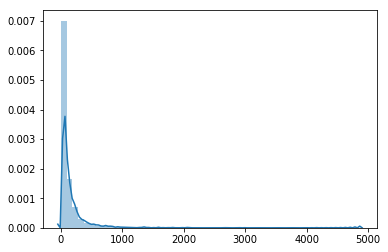

In [197]:
sns.distplot(ranks)

In [200]:
collections.Counter(ranks)

Counter({0: 186,
         1: 149,
         2: 171,
         3: 128,
         4: 116,
         5: 119,
         6: 107,
         7: 100,
         8: 107,
         9: 98,
         10: 88,
         11: 84,
         12: 103,
         13: 85,
         14: 91,
         15: 70,
         16: 73,
         17: 63,
         18: 94,
         19: 83,
         20: 67,
         21: 72,
         22: 61,
         23: 61,
         24: 66,
         25: 59,
         26: 62,
         27: 71,
         28: 62,
         29: 61,
         30: 58,
         31: 48,
         32: 47,
         33: 52,
         34: 65,
         35: 55,
         36: 48,
         37: 43,
         38: 48,
         39: 45,
         40: 44,
         41: 46,
         42: 37,
         43: 41,
         44: 44,
         45: 38,
         46: 48,
         47: 35,
         48: 34,
         49: 48,
         50: 36,
         51: 37,
         52: 44,
         53: 49,
         54: 40,
         55: 34,
         56: 29,
         57: 45,
         58: 3

## Scratch Pad

In [ ]:
#Get feature importances by getting coef per each feature
features = model.named_steps['vect'].get_feature_names()

coefficients = model.named_steps['clf'].coef_
coefficients = np.squeeze(coefficients)
coefficients = pd.DataFrame(
    {'features': features,
     'coefficients': coefficients
    })

coefficients.set_index('features', inplace = True)
coefficients['abs'] = abs(coefficients['coefficients'])
coeffcients = coefficients.sort_values(by= ['abs'], ascending = False, inplace = True)
coefficients['coefficients'][:30]

In [ ]:
pred = model.predict(X_test)

In [ ]:
#Get pipeline without classifier
pipeline_trans = deepcopy(pipeline)
pipeline_trans.steps.pop(2)
pipeline_trans.steps

In [ ]:
output = pipeline_trans.transform(X_test)

In [ ]:
output = pd.DataFrame(output.toarray())
output['title'] = title_test.reset_index(drop = True)
output['truth'] = y_test.reset_index(drop=True)
output['pred'] = pred

In [ ]:
output.head()

In [ ]:
coefficients = model.named_steps['clf'].coef_
coefficients = np.squeeze(coefficients)

In [ ]:
#what words are most associated with true positives?
tp_features_sum = (pd.DataFrame(output.loc[(output['truth'] == 1) & (output['pred'] == 1), ].mean(axis = 0))
                                .drop(['truth', 'pred']))

tp_features_sum['features'] = features
tp_features_sum['coefficients'] = coefficients
tp_features_sum.sort_values(by = 0, ascending = False, inplace = True)
tp_features_sum.head(20)

In [ ]:
#what words are most associated with false negatives?
fn_features_sum = (pd.DataFrame(output.loc[(output['truth'] == 1) & (output['pred'] == 0), ].mean(axis = 0))
                                .drop(['truth', 'pred']))

fn_features_sum['features'] = features
fn_features_sum['coefficients'] = coefficients
fn_features_sum.sort_values(by = 0, ascending = False, inplace = True)
fn_features_sum.head(20)

In [ ]:
for j in [10]:
    print(output.loc[(output['truth'] == 1) & (output['pred'] == 0), 'title'].iloc[j])
    print(X_test.reset_index(drop = True)[(output['truth'] == 1) & (output['pred'] == 0)].iloc[j])
    for i in np.squeeze(np.nonzero(output.loc[(output['truth'] == 1) & (output['pred'] == 0)].iloc[j, :-3])):
        print(features[i], coefficients[i])
    

In [ ]:
"""
#file pickle pipelines

with open('pipeline_trans.pickle', 'wb') as handle:
    pickle.dump(pipeline_trans, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('action_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('melan_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('roman_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('horror_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
"""

In [ ]:
model.steps

NameError: name 'exp' is not defined